<a href="https://colab.research.google.com/github/G0rav/Image_Segmentation/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.tensorflow.org/tutorials/images/segmentation

https://keras.io/examples/vision/oxford_pets_image_segmentation/

https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py

In [1]:
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt
% matplotlib inline

plt.rcParams['figure.facecolor'] = 'white'

In [2]:
pet, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVJGZSM/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVJGZSM/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [3]:
type(pet['train'])

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [5]:
images = list(pet['train'].map(lambda x: x['image']))
display(len(images))
display(images[0].shape, images[1].shape)

3680

TensorShape([500, 500, 3])

TensorShape([313, 500, 3])

In [6]:
segmentation_masks = list(pet['train'].map(lambda x: x['segmentation_mask']))
display(len(segmentation_masks))
display(segmentation_masks[0].shape, segmentation_masks[1].shape)

3680

TensorShape([500, 500, 1])

TensorShape([313, 500, 1])

In [7]:
labels = list(pet['train'].map(lambda x: x['label']))
display(len(labels))
display(labels[0], labels[1])

3680

<tf.Tensor: shape=(), dtype=int64, numpy=33>

<tf.Tensor: shape=(), dtype=int64, numpy=12>

In [8]:
dir(labels[0])

['OVERLOADABLE_OPERATORS',
 '_USE_EQUALITY',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__complex__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__iter__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmatmul__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_add_consumer',


In [9]:
species = list(pet['train'].map(lambda x: x['species']))
display(len(species))
display(species[0], species[1])

3680

<tf.Tensor: shape=(), dtype=int64, numpy=0>

<tf.Tensor: shape=(), dtype=int64, numpy=1>

species: tf.Tensor(0, shape=(), dtype=int64)
label: tf.Tensor(33, shape=(), dtype=int64)


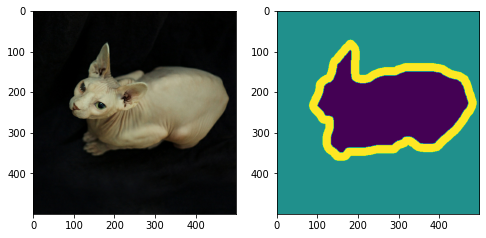

species: tf.Tensor(1, shape=(), dtype=int64)
label: tf.Tensor(34, shape=(), dtype=int64)


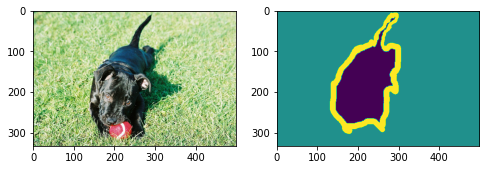

species: tf.Tensor(0, shape=(), dtype=int64)
label: tf.Tensor(5, shape=(), dtype=int64)


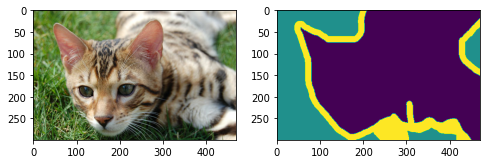

species: tf.Tensor(1, shape=(), dtype=int64)
label: tf.Tensor(31, shape=(), dtype=int64)


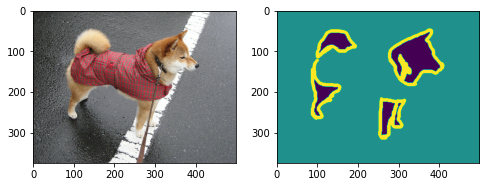

species: tf.Tensor(1, shape=(), dtype=int64)
label: tf.Tensor(30, shape=(), dtype=int64)


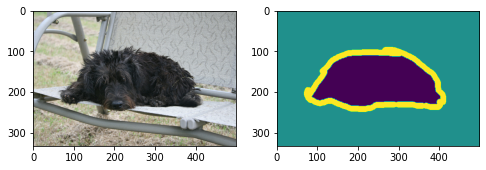

species: tf.Tensor(1, shape=(), dtype=int64)
label: tf.Tensor(10, shape=(), dtype=int64)


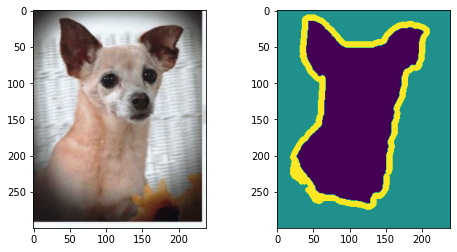

In [10]:
for i in [0,100,500,1000,2000,3000]:
  print(f'species:',species[i])
  print(f'label:',labels[i])

  plt.figure(figsize = (8,4))
  plt.subplot(121)
  image = np.array(images[i])
  plt.imshow(image)

  plt.subplot(122)
  mask = np.array(segmentation_masks[i])
  mask = mask.reshape(mask.shape[0], mask.shape[1])
  plt.imshow(mask)
  plt.show()


In [17]:
mask = np.array(segmentation_masks[0])
print(mask.shape)
print(np.unique(mask))

mask-=1
print(mask.shape)
print(np.unique(mask))

(500, 500, 1)
[1 2 3]
(500, 500, 1)
[0 1 2]


## Create Dataset

In [18]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [19]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [20]:
train = pet['train'].map(load_image)
test = pet['test'].map(load_image)

In [21]:
train

<MapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>

In [22]:
type(train)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [23]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask

display(sample_image)
print('*'*100)
display(sample_mask)

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.01960784, 0.01273648, 0.01374272],
        [0.0214815 , 0.01618605, 0.01246458],
        [0.01385474, 0.01740866, 0.0156317 ],
        ...,
        [0.00884842, 0.00308862, 0.00596852],
        [0.00824621, 0.00824621, 0.00459559],
        [0.02745098, 0.01176471, 0.01213235]],

       [[0.01471546, 0.01599265, 0.01032954],
        [0.01438323, 0.01438323, 0.01539618],
        [0.01582893, 0.01213905, 0.01398399],
        ...,
        [0.00665882, 0.00274395, 0.00377891],
        [0.00795324, 0.00795324, 0.00101294],
        [0.01200023, 0.01200023, 0.01481886]],

       [[0.01036209, 0.01726122, 0.01381166],
        [0.01331667, 0.01331667, 0.01331667],
        [0.01387963, 0.01963944, 0.0146762 ],
        ...,
        [0.00707816, 0.00707816, 0.00707816],
        [0.01545458, 0.01176471, 0.01152631],
        [0.01783088, 0.00998775, 0.01966912]],

       ...,

       [[0.02640931, 0.02875594, 0.03659907],
        [0.01

****************************************************************************************************


<tf.Tensor: shape=(128, 128, 1), dtype=float32, numpy=
array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]], dtype=float32)>

In [24]:
len(train), len(test)

(3680, 3669)

In [25]:
info.splits['train'].num_examples

3680

In [26]:
3680/64

57.5

In [27]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [28]:
train_dataset

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

In [29]:
dir(train_dataset)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_add_variable_with_custom_getter',
 '_apply_options',
 '_as_serialized_graph',
 '_buffer_size',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_has_captured_ref',
 '_input_dataset',
 '_inputs',
 '_list_extra_dependencies_for_serializat

In [30]:
for image, mask in train_dataset.take(1):
  sample_image, sample_mask = image, mask

display(sample_image)
print('*'*100)
display(sample_mask)

<tf.Tensor: shape=(64, 128, 128, 3), dtype=float32, numpy=
array([[[[4.83999699e-01, 5.09980083e-01, 4.67095584e-01],
         [4.74900424e-01, 4.83846515e-01, 4.51899499e-01],
         [4.66509640e-01, 4.74352777e-01, 4.27006751e-01],
         ...,
         [1.39847577e-01, 1.60680920e-01, 1.68769151e-01],
         [1.38357848e-01, 1.69730395e-01, 1.77573532e-01],
         [1.44852936e-01, 1.76470593e-01, 1.58088237e-01]],

        [[5.03469646e-01, 5.03714740e-01, 4.72342223e-01],
         [4.33118880e-01, 4.40962017e-01, 3.88660371e-01],
         [3.16126674e-01, 3.16616893e-01, 2.69312948e-01],
         ...,
         [1.29836857e-01, 1.70530796e-01, 1.58149511e-01],
         [1.33490354e-01, 1.67681530e-01, 1.71296716e-01],
         [1.51409313e-01, 1.63419113e-01, 1.82536766e-01]],

        [[4.84129906e-01, 5.00513196e-01, 4.57460165e-01],
         [4.06250000e-01, 4.11148131e-01, 3.47606450e-01],
         [4.43390012e-01, 4.47311580e-01, 3.84566486e-01],
         ...,
         [

****************************************************************************************************


<tf.Tensor: shape=(64, 128, 128, 1), dtype=float32, numpy=
array([[[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        ...,

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]]],


       [[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
   

## Model building

In [31]:
from tensorflow.keras import layers
from tensorflow import keras

In [32]:
import math

def output_size(n,f, s=1, p=0):
  if p == 'same':
    p = 1
  return math.ceil((n - f + 2*p)/s + 1)

In [33]:
output_size(128,3,1,'same')

128

In [45]:
input_layer = layers.Input(shape = [128,128,3])

conv1 = layers.Conv2D(32, 3, padding="same", activation="relu")(input_layer)
conv1 = layers.Conv2D(32, 3, padding="same", activation="relu")(conv1)
pool1 = layers.MaxPooling2D(2)(conv1)

conv2 = layers.Conv2D(64, 3, padding="same", activation="relu")(pool1)
conv2 = layers.Conv2D(64, 3, padding="same", activation="relu")(conv2)
pool2 = layers.MaxPooling2D(2)(conv2)

conv3 = layers.Conv2D(128, 3, padding="same", activation="relu")(pool2)
conv3 = layers.Conv2D(128, 3, padding="same", activation="relu")(conv3)
pool3 = layers.MaxPooling2D(2)(conv3)

conv4 = layers.Conv2D(256, 3, padding="same", activation="relu")(pool3)
conv4 = layers.Conv2D(256, 3, padding="same", activation="relu")(conv4)
pool4 = layers.MaxPooling2D(2)(conv4)

#Bottom
conv5 = layers.Conv2D(512, 3, padding="same", activation="relu")(pool4)
conv5 = layers.Conv2D(512, 3, padding="same", activation="relu")(conv5)

#upsampling
deconv4 = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(conv5)
unconv4 = layers.concatenate([deconv4, conv4])
unconv4 = layers.Conv2D(256, 3, padding="same", activation="relu")(unconv4)
unconv4 = layers.Conv2D(256, 3, padding="same", activation="relu")(unconv4)

deconv3 = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(unconv4)
unconv3 = layers.concatenate([deconv3, conv3])
unconv3 = layers.Conv2D(128, 3, padding="same", activation="relu")(unconv3)
unconv3 = layers.Conv2D(128, 3, padding="same", activation="relu")(unconv3)

deconv2 = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(unconv3)
unconv2 = layers.concatenate([deconv2, conv2])
unconv2 = layers.Conv2D(64, 3, padding="same", activation="relu")(unconv2)
unconv2 = layers.Conv2D(64, 3, padding="same", activation="relu")(unconv2)

deconv1 = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(unconv2)
unconv1 = layers.concatenate([deconv1, conv1])
unconv1 = layers.Conv2D(32, 3, padding="same", activation="relu")(unconv1)
unconv1 = layers.Conv2D(32, 3, padding="same", activation="relu")(unconv1)

output_layer = layers.Conv2D(3, 3, padding="same", activation="sigmoid")(unconv1)

model = keras.Model(input_layer, output_layer)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_39[0][0]                  
____________________________________________________________________________________________

TensorShape([128, 128, 3])

****************************************************************************************************


TensorShape([128, 128, 1])

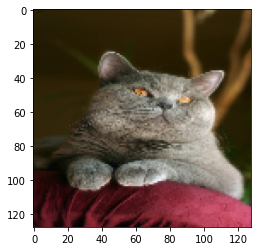

img.reshape <built-in method reshape of numpy.ndarray object at 0x7f21a14a4990>
pred.shape (1, 128, 128, 3)
pred.shape (128, 128)


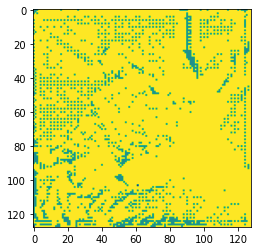

In [46]:
for image, mask in train.take(3):
  sample_image, sample_mask = image, mask

display(sample_image.shape)
print('*'*100)
display(sample_mask.shape)

img = np.array(sample_image)
plt.imshow(img)
plt.show()

img = img.reshape((1,) + img.shape)
print('img.reshape',img.reshape)

pred = model.predict(img)
print('pred.shape',pred.shape)

pred = np.argmax(pred, axis=-1)
pred = pred.reshape(pred.shape[1:])

print('pred.shape',pred.shape)
plt.imshow(pred)
plt.show()

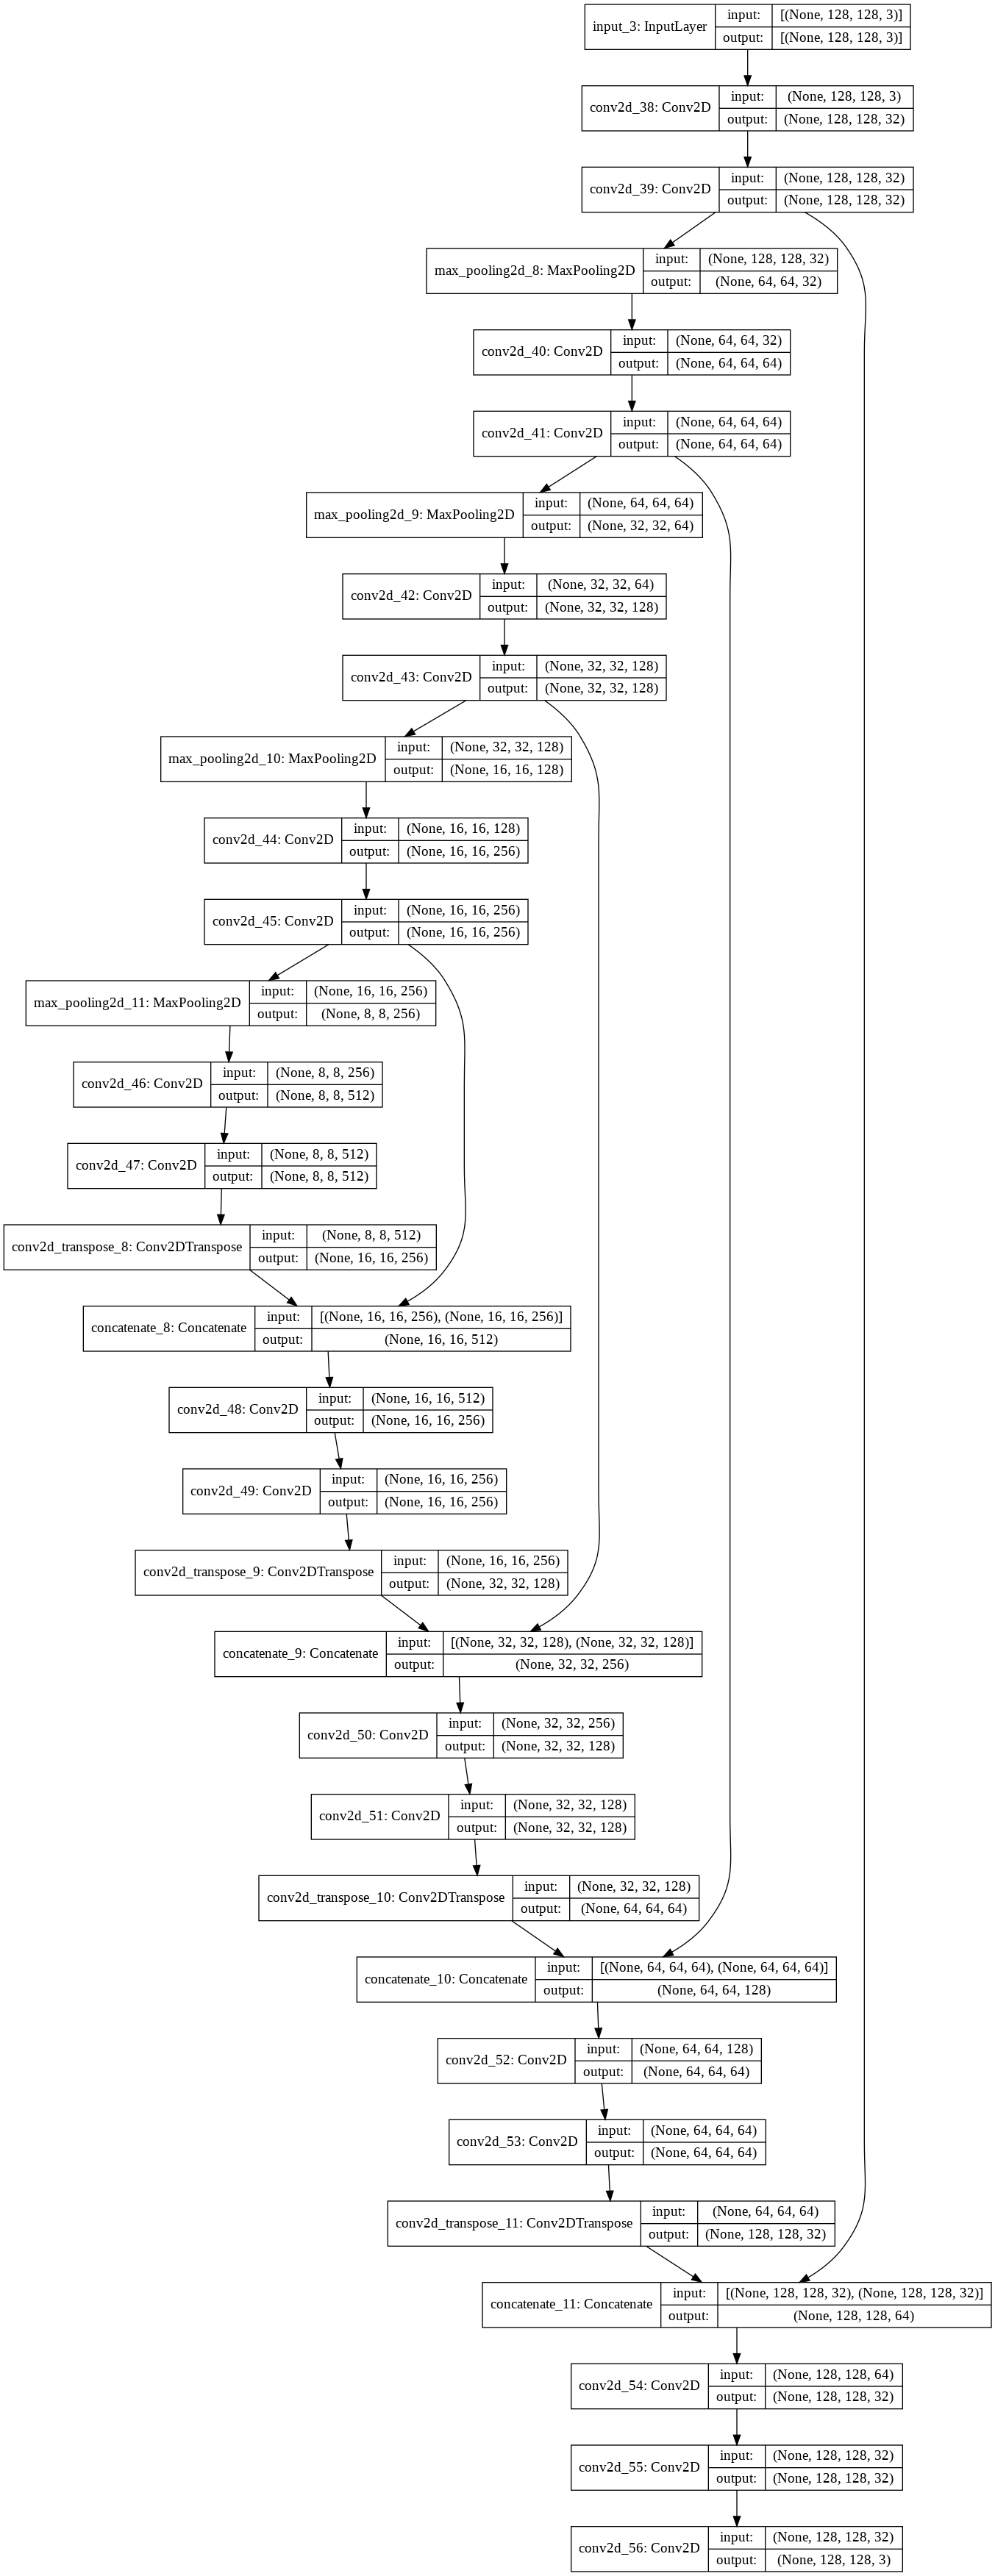

In [47]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [48]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model_history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/15
58/58 [==============================] - 38s 535ms/step - loss: 0.9571 - val_loss: 0.8447
Epoch 2/15
58/58 [==============================] - 28s 483ms/step - loss: 0.7906 - val_loss: 0.7299
Epoch 3/15
58/58 [==============================] - 27s 473ms/step - loss: 0.6924 - val_loss: 0.6729
Epoch 4/15
58/58 [==============================] - 28s 489ms/step - loss: 0.6402 - val_loss: 0.5979
Epoch 5/15
58/58 [==============================] - 28s 482ms/step - loss: 0.5835 - val_loss: 0.5779
Epoch 6/15
58/58 [==============================] - 28s 484ms/step - loss: 0.5562 - val_loss: 0.5321
Epoch 7/15
58/58 [==============================] - 28s 484ms/step - loss: 0.4983 - val_loss: 0.4568
Epoch 8/15
58/58 [==============================] - 28s 485ms/step - loss: 0.4506 - val_loss: 0.4342
Epoch 9/15
58/58 [==============================] - 28s 484ms/step - loss: 0.4316 - val_loss: 0.4444
Epoch 10/15
58/58 [==============================] - 28s 484ms/step - loss: 0.4044 - val_lo

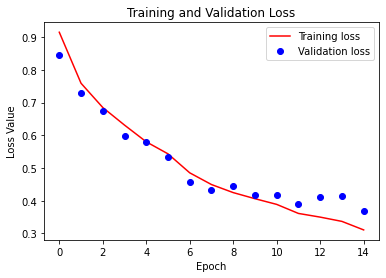

In [49]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']


plt.figure()
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [50]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [51]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [52]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in train_dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

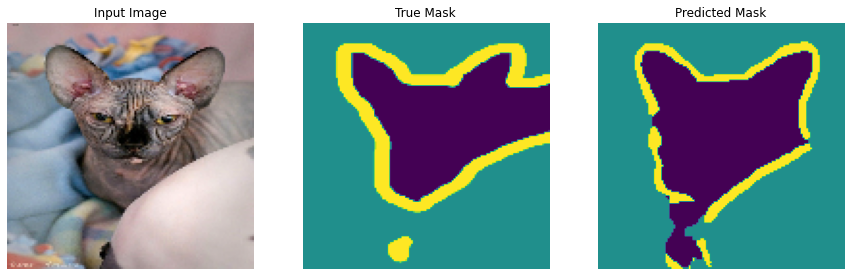

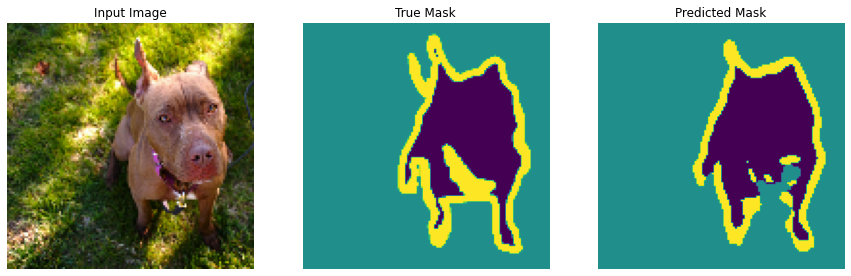

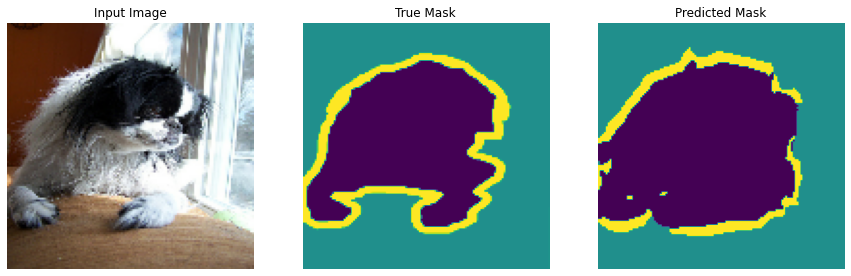

In [53]:
show_predictions(test_dataset, 3)

(128, 128, 3)
****************************************************************************************************
(128, 128, 1)


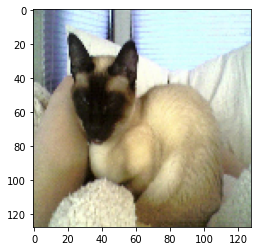

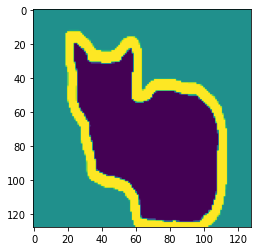

<built-in method reshape of numpy.ndarray object at 0x7f219017fc10>
(1, 128, 128, 3)


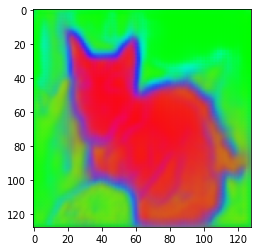

In [58]:
for image, mask in train.take(300):
  sample_image, sample_mask = image, mask

print(sample_image.shape)
print('*'*100)
print(sample_mask.shape)

img = np.array(sample_image)
plt.imshow(img)
plt.show()

mask = np.array(sample_mask)
mask = mask.reshape(mask.shape[0], mask.shape[1])
plt.imshow(mask)
plt.show()

img = img.reshape((1,) + img.shape)
print(img.reshape)

pred = model.predict(img)
print(pred.shape)

pred = pred.reshape(pred.shape[1:])

plt.imshow(pred)
plt.show()

In [59]:
pred_mask = tf.argmax(pred, axis=-1)
#pred_mask = pred_mask[..., tf.newaxis]
pred_mask

<tf.Tensor: shape=(128, 128), dtype=int64, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])>

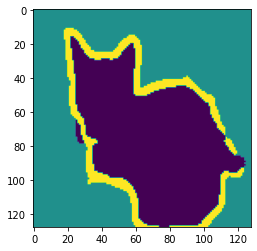

In [60]:
plt.imshow(pred_mask)
plt.show()

#copied

In [ ]:
input_layer = layers.Input(shape = [128,128,3])

conv1 = layers.Conv2D(32, 3, strides=1, padding="same")(input_layer)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.Activation("relu")(conv1)

conv1 = layers.Conv2D(32, 3, strides=1, padding="same")(conv1)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.Activation("relu")(conv1)

pool1 = layers.MaxPooling2D(2)(conv1)


model = keras.Model(input_layer, pool1)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0   

In [ ]:
xxxxx